# v1 - 基礎模型建立

In [0]:
!nvidia-smi
!pip install -U git+https://github.com/qubvel/efficientnet

In [0]:
%tensorflow_version 2.x
import zipfile
import os
import csv
import numpy as np
import shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
STEPS = 64
NUM_EPOCHS = 40
NUM_CLASSES = 3
DATASET_PATH = '/content/C1-P1_Train_Dev/C1-P1/'       # 資料路徑

# 載入、分類資料

In [0]:
def image_class():
    train_test_split = 0.2

    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/AIMango_sample/C1-P1_Train_Dev.zip")
    f.extractall("./")

    # 依分類建立資料夾
    if not os.path.isdir(DATASET_PATH + 'A'):
        os.mkdir(DATASET_PATH + 'A')
    if not os.path.isdir(DATASET_PATH + 'B'):
        os.mkdir(DATASET_PATH + 'B')
    if not os.path.isdir(DATASET_PATH + 'C'):
        os.mkdir(DATASET_PATH + 'C')
    
    with open('/content/C1-P1_Train_Dev/C1-P1.csv') as csvfile:
        rows = csv.reader(csvfile)

        level_path = {'A': [], 'B': [], 'C': []}
        for row in rows:
            level_path[row[1][-1]].append(DATASET_PATH + row[0])

        for lvl in level_path:            
            for i, img_path in enumerate(tqdm(level_path[lvl])):
                shutil.move(img_path, DATASET_PATH + lvl)
                
if not os.path.exists('/content/C1-P1_Train_Dev'):
    image_class()

# 載入、處理影像
    1. Normalized to 0 - 1
    2. resize
    3. Split train、label
    4. label do One-Hot encoding
    5. train_test_split

In [0]:
from glob import glob
import cv2

class_map = {'A': 0, 'B': 1, 'C': 2}
IMG_PATH = glob('/content/C1-P1_Train_Dev/C1-P1/*/*.jpg')
np.random.shuffle(IMG_PATH) # 打亂順序

data_count = len(IMG_PATH)
X_dataset = np.zeros((data_count, IMAGE_SIZE, IMAGE_SIZE, 3)).astype('float32')
Y_dataset = np.zeros((data_count, )).astype('float32')

for i, path in enumerate(tqdm(IMG_PATH)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.
    img_resize = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)).astype('float32')
    cls = path.split('/')[-2]
    
    X_dataset[i] = img_resize
    Y_dataset[i] = class_map[cls]

In [0]:
import pandas as pd

unique, counts = np.unique(Y_dataset, return_counts=True)
pd.DataFrame(counts, index = ['A', 'B', 'C'])

,0
A,2035
B,2361
C,2004


In [0]:
from tensorflow.keras.utils import to_categorical

y_onehot = to_categorical(Y_dataset, num_classes=NUM_CLASSES, dtype='uint8')

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_dataset, y_onehot, test_size=0.2, random_state=123)

# CNN、FC 模型建立

In [0]:
import efficientnet.tfkeras as efn
from tensorflow.keras import Model
import tensorflow.keras.layers as L

net = efn.EfficientNetB7(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights='noisy-student',
                         include_top=False)

x = net.output
x = L.Flatten()(x)
x = L.Dropout(0.5)(x)
x = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=x)

258072576/258068648 [==============================] - 3s 0us/step


# 模型編譯 optimizer、loss、metrics

In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# 模型訓練

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/40
512/512 [==============================] - 185s 361ms/step - loss: 4.7570 - categorical_accuracy: 0.4446 - val_loss: 7.0717 - val_categorical_accuracy: 0.4072
Epoch 2/40
512/512 [==============================] - 180s 352ms/step - loss: 3.5385 - categorical_accuracy: 0.5508 - val_loss: 2.1424 - val_categorical_accuracy: 0.6426
Epoch 3/40
512/512 [==============================] - 179s 349ms/step - loss: 3.2335 - categorical_accuracy: 0.5605 - val_loss: 31.2107 - val_categorical_accuracy: 0.5107
Epoch 4/40
512/512 [==============================] - 180s 352ms/step - loss: 2.9410 - categorical_accuracy: 0.6042 - val_loss: 3.3891 - val_categorical_accuracy: 0.5879
Epoch 5/40
512/512 [==============================] - 181s 353ms/step - loss: 2.4291 - categorical_accuracy: 0.6265 - val_loss: 2.3008 - val_categorical_accuracy: 0.5840
Epoch 6/40
512/512 [==============================] - 181s 353ms/step - loss: 2.2322 - categorical_accuracy: 0.6411 - val_loss: 4.1950 - val_categori

# Plot accuracy

Text(0.5, 1.0, 'acc')

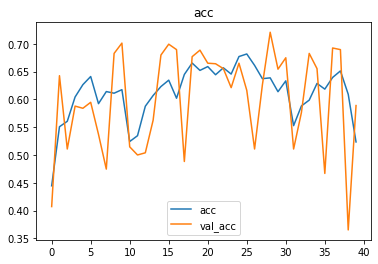

In [0]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

# Plot loss 

Text(0.5, 1.0, 'loss')

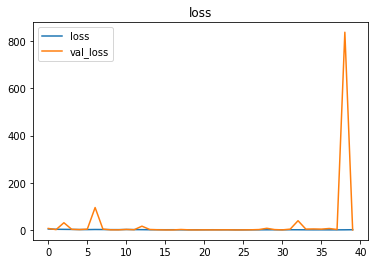

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

# 評估、預測模型

In [0]:
loss, acc = model.evaluate(x_test, y_test, steps=STEPS)
print('評估的準確率: ', acc)

ans = model.predict(x_test)
print('預測的結果: ', ans.argmax(axis=-1))

64/64 [==============================] - 9s 144ms/step - loss: 0.9377 - categorical_accuracy: 0.5773
評估的準確率:  0.577343761920929
預測的結果:  [2 1 2 ... 2 0 1]
